<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Transfer Learning Fine-tuning

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [3]:
SEMENTE = 2008193

DIR_TREINO    = '10_food_classes_all_data/train'
DIR_TREINO_10 = '10_food_classes_10_percent/train'
DIR_TREINO_1  = '10_food_classes_1_percent/train'
DIR_TESTE     = '10_food_classes_all_data/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
# APRENDIZADO = 0.001

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-23 01:52:44--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4049 (4.0K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   3.95K  --.-KB/s    in 0s      

2023-01-23 01:52:44 (56.4 MB/s) - ‘funcoes.py’ saved [4049/4049]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_perda_precisao_por_iteracao, unzip_data, walk_through_dir

## Dados

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_all_data.zip')
unzip_data('10_food_classes_10_percent.zip')
unzip_data('10_food_classes_1_percent.zip')

--2023-01-23 01:52:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   108MB/s    in 4.2s    

2023-01-23 01:52:49 (117 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

--2023-01-23 01:52:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 O

In [7]:
# walk_through_dir('10_food_classes_all_data')

### Importando os dados e tranformando-os em lotes

In [8]:
dados_treino = image_dataset_from_directory(directory=DIR_TREINO,
                                            batch_size=TAMANHO_LOTE,
                                            image_size=FORMATO_IMAGEM,
                                            label_mode=MODO_CLASSE,
                                            seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           seed=SEMENTE)

dados_treino_10 = image_dataset_from_directory(directory=DIR_TREINO_10,
                                               batch_size=TAMANHO_LOTE,
                                               image_size=FORMATO_IMAGEM,
                                               label_mode=MODO_CLASSE,
                                               seed=SEMENTE)

dados_treino_1 = image_dataset_from_directory(directory=DIR_TREINO_1,
                                              batch_size=TAMANHO_LOTE,
                                              image_size=FORMATO_IMAGEM,
                                              label_mode=MODO_CLASSE,
                                              seed=SEMENTE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 70 files belonging to 10 classes.


In [9]:
# image_dataset_from_directory retorna um BatchDataset

# O primeiro tensor contém as imagens. DADOS NÃO ESCALONADOS.
# O tamanho do lote não está especificado, mesmo que tenha sido informado.
# Os canais de cores estão definidos pelo parâmetro color_mode='rgb' (default).

# O segundo tensor contém as classes em formato one-hot.

dados_treino

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
rotulos = dados_treino.class_names
# rotulos

### Criando modelo

The Functional API: https://www.tensorflow.org/guide/keras/functional

Modelos pré-treinados: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [11]:
# Criar um modelo-base a partir de um modelo pré-treinado.
# EfficientNetB0 foi treinado com a ImageNet, portanto a camada no topo tem 1000 entradas.
# Nossos dados possuem 10 classes, portanto não utilizaremos a camada no topo padrão. (include_top=False)
modelo_base = EfficientNetB0(include_top=False)

# "Congelar" o modelo-base, para que os padrões pré-treinados não sejam odificados durante o treinamento.
modelo_base.trainable = False

# Camada de entrada.
entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
# Modelos EfficientNet possuem escalonamento interno.
# camadas = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(entradas)
# Obs.: acredito que a camada de escalonamento devia ser adicionada à 'entradas', não 'camadas'.

# Carregar as entradas no modelo-base.
camadas = modelo_base(entradas)

# Agrupar a média global do modelo-base.
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

# Camada de saída.
saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

# Reunir camadas de entrada e saída em um modelo.
modelo_00 = Model(inputs=entradas,
                  outputs=saidas,
                  name='Modelo_00')

# Compilar o modelo.
modelo_00.compile(loss=PERDA,
                  optimizer=Adam(),
                  metrics=METRICAS)

# Ajustar o modelo, gravando histórico e criando logs TensorBoard.
historico_00 = modelo_00.fit(dados_treino_10,
                             epochs=5,
                             steps_per_epoch=len(dados_treino_10),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_00_10_por_cento')],
                             verbose=1)

16705208/16705208 [==============================] - 0s 0us/step
Salvando log TensorBoard em: 'transfer_learning/modelo_00_10_por_cento/20230123-015309'.
Epoch 1/5
24/24 [==============================] - 23s 404ms/step - loss: 1.7859 - accuracy: 0.4893 - val_loss: 1.2490 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 8s 315ms/step - loss: 1.0608 - accuracy: 0.7720 - val_loss: 0.8510 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 8s 319ms/step - loss: 0.7706 - accuracy: 0.8213 - val_loss: 0.6845 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 8s 315ms/step - loss: 0.6328 - accuracy: 0.8547 - val_loss: 0.6019 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 8s 315ms/step - loss: 0.5442 - accuracy: 0.8760 - val_loss: 0.5505 - val_accuracy: 0.8632


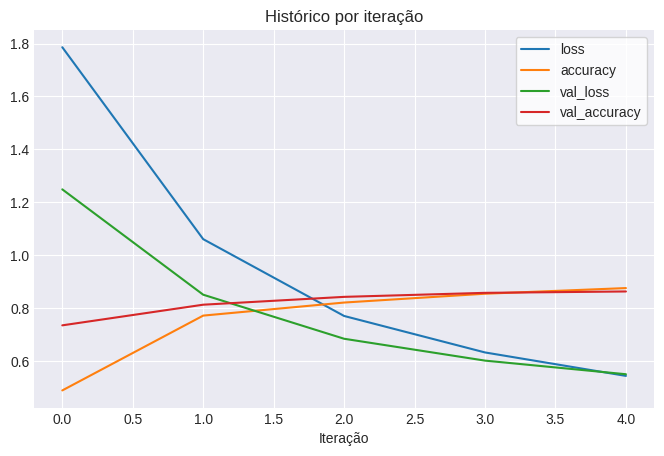

In [12]:
grafico_perda_precisao_por_iteracao(historico_00)

In [18]:
modelo_00.summary()

Model: "Modelo_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_entrada (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 agrupamento_media_global (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 camada_saida (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________
